# Chapter 3: Modern Neural Networks - Optimizers

In Chapter 3, we presented several modern algorithms derived from SGD, improving the optimization process. This notebook will showcase their usage and effects on the training of our CNN for digit classification.

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

## Preparing the Data

We prepare the [MNIST](http://yann.lecun.com/exdb/mnist) data, the same way it was done in the previous notebooks:

In [2]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

## Preparing the Model

We also reuse the LeNet-5 model we previously implemented. However, we wrap its instantiation into a function, so that we can spawn multiple ones:

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [4]:
def lenet(name='lenet'):
    model = Sequential(name=name)
    # 1st block:
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 2nd block:
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dense layers:
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## Training with Various Optimizers


In [5]:
from tensorflow.keras import optimizers

To showcase the effect that modern optimizers (available in Tensorflow and Keras) have on trainings, we will create several similar LeNet instance, and train each with a different optimizer.

First, we instantiate the various optimizers we want to apply:

In [6]:
optimizers_examples = {
    'sgd': optimizers.SGD(),
    'momentum': optimizers.SGD(momentum=0.9),
    'nag': optimizers.SGD(momentum=0.9, nesterov=True),
    'adagrad': optimizers.Adagrad(),
    'adadelta': optimizers.Adadelta(),
    'rmsprop': optimizers.RMSprop(),
    'adam': optimizers.Adam()
}

For each optimizer we are considering, we will instantiate a new LeNet model and train it with. We will save their training `history` (containing the losses and metrics history over training), for comparison *(this process takes time, especially on CPU!)*:

In [7]:
history_per_optimizer = dict()

for optimizer_name in optimizers_examples:
    # Resetting the seeds (for random number generation), to reduce the impact of randomness on the comparison:
    tf.set_random_seed(42)
    np.random.seed(42)
    # Creating the model:
    model = lenet("lenet_{}".format(optimizer_name))
    optimizer = optimizers_examples[optimizer_name]
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Launching the training (we set `verbose=0`, so the training won't generate any logs):
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=20, validation_data=(x_test, y_test),
                        verbose=0)
    history_per_optimizer[optimizer_name] = history
    print('> Training with {}: done.'.format(optimizer_name))

> Training with sgd: done.
> Training with momentum: done.
> Training with nag: done.
> Training with adagrad: done.
> Training with adadelta: done.
> Training with rmsprop: done.
> Training with adam: done.


We finally plot the training and validation losses + accuracies, for comparison:

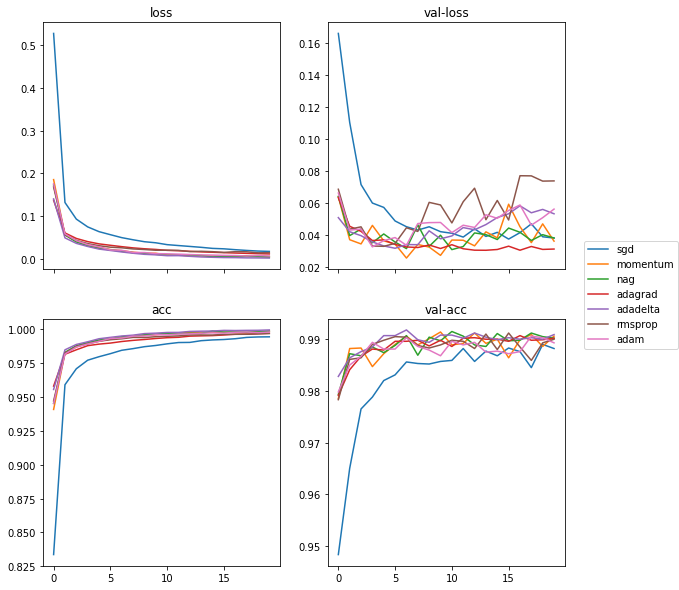

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")

lines, labels = [], []
for optimizer_name in history_per_optimizer:
    history = history_per_optimizer[optimizer_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['acc'])
    line = ax[1, 1].plot(history.history['val_acc'])
    lines.append(line[0])
    labels.append(optimizer_name)

fig.legend(lines,labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.85)

Though the end accuracy on the validation set doesn't differ by much from one instance to another, we can clearly observe how much faster models trained with more advanced optimizers converge.
